<a href="https://colab.research.google.com/github/ayami-n/Flax_text_prediction/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Flax_text_prediction

/content/drive/MyDrive/Flax_text_prediction


# Import libs

In [ ]:
%%capture
!pip install datasets
!pip install git+https://github.com/huggingface/transformers.git
!pip install flax
!pip install git+https://github.com/deepmind/optax.git

In [3]:
import jax
from jax import random  # to create random values for initalizing a model (Flax requires)
import jax.numpy as jnp

# Flax for building model
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

from flax import linen as nn
from flax.training import train_state, checkpoints

# Optax for optimizor 
import optax

# Transformers
!pip install transformers
from transformers import FlaxAutoModelForSequenceClassification, AutoConfig
from transformers import RobertaTokenizer, RobertaConfig # as we use Roberta model

# others
import pandas as pd
from tqdm import tqdm

     |████████████████████████████████| 197 kB 36.2 MB/s 
     |████████████████████████████████| 217 kB 67.4 MB/s 
     |████████████████████████████████| 145 kB 53.5 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 
     |████████████████████████████████| 72 kB 584 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 33.7 MB/s 
     |████████████████████████████████| 6.6 MB 68.2 MB/s 
     |████████████████████████████████| 101 kB 11.0 MB/s 


# Config

In [4]:
model_checkpoint = 'siebert/sentiment-roberta-large-english' # https://huggingface.co/docs/transformers/model_doc/roberta#roberta
num_labels = 3 # our targets
seed = 0  # for building our model
max_len = 256  # input text should be the same length (most words <= 256)

config = AutoConfig.from_pretrained(model_checkpoint, num_labels=num_labels)  # create a config for our model
tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)  # this tokenizer converts numeric from string: the values are different if you select different model_checkpoint

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

# Tokenaization

In [8]:
'''
https://stackoverflow.com/questions/65246703/how-does-max-length-padding-and-truncation-arguments-work-in-huggingface-bertt
adding [CLS] token at the beginning of the sentence, and [SEP] token at the end of sentence.
[CLS] I love you [SEP] is expected by BERT. 
tokenizer gives [CLS] and [SEP] usually
'''

In [10]:
df = pd.read_csv("./kaggle/train.csv")  # import train datasets
new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}  # to replace 
df = df.replace(new_label) 

In [33]:
max = 0
max_str = "Hello"
words_list = []
for itr, val in enumerate(df['discourse_text'].to_numpy()):
  words = val.split()
  words_list.append(len(words))

  if len(words) > max:
    max = len(words)
    max_str = val

print(pd.Series(list(filter(lambda x: (x <= 256), words_list))).count(), len(words_list))    

36566 36765


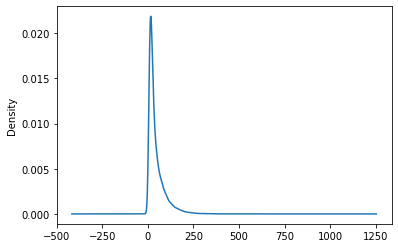

In [36]:
'''
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.kde.html
'''
pd.Series(words_list).plot.kde()

In [ ]:
def tokenaize(texts, tokenizer, max_len):  # df text comes and return as numerical 
    input_ids = []
    attention_mask = []
    
    for text in tqdm(texts):  # it takes over 1 min (numpy and list)
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length', return_tensors='jax') # add_special_tokens=True is default: truncation=True is cutting off longer sentences (longer than max_length)
        input_ids.append(token['input_ids']) # separate: the values (text) are converted by the tokenizer
        attention_mask.append(token['attention_mask']) # separate: the values (attention-mask) are converted by the tokenizer
        
    return jnp.array(input_ids), jnp.array(attention_mask)

In [ ]:
input_ids, attention_mask = tokenaize(df['discourse_text'].to_numpy(), tokenizer, max_len)  # pandas is slow -> numpy is the fastest (list is considerable)

# Create a model

In [38]:
label = jnp.array(df['discourse_effectiveness'].to_numpy())  # jnp (DeviceArray) as model requires

In [ ]:
model = FlaxAutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config, seed=seed, ignore_mismatched_sizes=True)  # ignore_mismatched_sizes=True: arrow to have arbitary number of outputs

Some weights of FlaxRobertaForSequenceClassification were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized because the shapes did not match:
- ('classifier', 'out_proj', 'bias'): found shape (2,) in the checkpoint and (3,) in the model instantiated
- ('classifier', 'out_proj', 'kernel'): found shape (1024, 2) in the checkpoint and (1024, 3) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
out = model(**inputs)
print(out)
print(out.logits)

FlaxSequenceClassifierOutput(logits=DeviceArray([[-0.4148041 , -0.48419115,  0.02517768]], dtype=float32), hidden_states=None, attentions=None)
[[-0.4148041  -0.48419115  0.02517768]]


# Validation

In [ ]:
test = pd.read_csv("./kaggle/test.csv") 